### Импорт библиотек

In [1]:
# Импорт библиотек для проведения расчетов
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics

In [2]:
# Импорт библиотек для визуализации
from matplotlib import pyplot as plt
import seaborn as sns

## Загрузка данных

In [3]:
# Указываем путь к файлу
# При работе с google colab существует 2 варианта загрузки файла:
# 1. Через google drive
# 2. Через левое меню: "файлы" -> "загрузить в сессионное хранилище" -> "скопировать файл" (при наведении на файл)
file_path = 'mnist_small.csv'

In [4]:
# Загружаем данные из CSV файла
df = pd.read_csv(file_path)
# Пример данных
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Формирование признакового пространства

In [5]:
# Набор данных содержит подмножество эталонного набора данных рукописных цифр MNIST. 
# 5923 картинок с изображением нуля и 76 картинок с изображением шестерки. 

# Сформируем признаковое пространство:
# Целевая переменная: label. Описывает метку изображения: 0 (основная выборка) или 6 (аномалия)
# Остальные переменные - входные.

# Задача - на основе методов обучения без учителя построить одноклассовую модель на основе поиска аномалий, 
# которая максимально хорошо отфильтрует шестерки (как аномалии) от нулей (как основную выборку). 
# Признаки картинок описываются их координатами (в названии переменных, например «10x12») и значением яркости точки по этим координатам.

y = df["label"]
y[y > 0] = 1
X = df.loc[:, sorted(list(set(df.columns) - {"label"}))]

scaler = StandardScaler()
X.values[:] = scaler.fit_transform(X)

In [169]:
# Данный код строит график ROC кривой вашей модели с референсной линией, соответствующей равным ошибкам первого и второго рода. 
# На пересечении этих графиков и будет точка EER (Equal Error Rate) вашей модели, которую вам нужно будет улучшить. 
# Обратите внимание на график, отметьте для себя точку пересечения графиков, соответствующую ERR вашей модели.
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    eer = fpr[np.argmin(np.abs(1 - tpr - fpr))] # EER - абсцисса (FPR) точки пересечения двух графиков
    print(f'EER = {eer}')
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [1, 0], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#### Вашей задачей является настроить целевой алгоритм (SVM для 1го варианта, Cluster для 2го варианта), а также при необходимости преобразовать и отобрать переменные без использования информации об отклике так, чтобы уменьшить ERR получаемой модели.

## Вариант 2: Clustering

EER = 0.08509201418200237


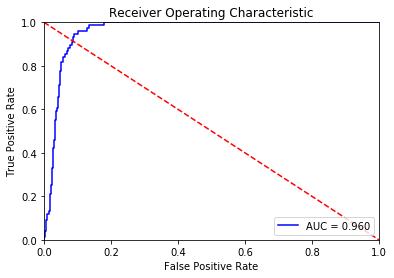

In [72]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
dist_clusters = X.apply(lambda x: min([np.linalg.norm(x - cl) for cl in kmeans.cluster_centers_]), axis = 1)
plot_roc_curve(y, dist_clusters)

Используем метод главных компонент для снижения размерности исходных данных. Количество компонент будем перебирать от 1 до 10. Для каждого из них применим KMeans и рассчитаем значение EER. Выберем среди них минимальное EER.

In [170]:
from sklearn.decomposition import PCA

In [171]:
eers = []
for n in range(1, 11):
    pca = PCA(n_components=n)
    pca.fit(X)
    X_ = pd.DataFrame(pca.transform(X))
    kmeans = KMeans(n_clusters=4, random_state=0).fit(X_)
    dist_clusters = X_.apply(lambda x: min([np.linalg.norm(x - cl) for cl in kmeans.cluster_centers_]), axis = 1)
    fpr, tpr, threshold = metrics.roc_curve(y, dist_clusters)
    eer = fpr[np.argmin(np.abs(1 - tpr - fpr))]
    eers.append(eer)

EER = 0.06989701164950195


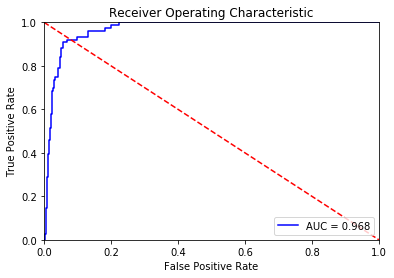

In [172]:
pca = PCA(n_components=np.argmin(eers)+1)
pca.fit(X)
X_ = pd.DataFrame(pca.transform(X))

kmeans = KMeans(n_clusters=4, random_state=0).fit(X_)
dist_clusters = X_.apply(lambda x: min([np.linalg.norm(x - cl) for cl in kmeans.cluster_centers_]), axis = 1)
plot_roc_curve(y, dist_clusters)

Значение EER удалось понизить примерно на 0.015